In [106]:
# use kernel py3-6
#import goatools
from goatools import obo_parser
import re
import json
import numpy as np
from goatools.go_enrichment import GOEnrichmentStudy
import matplotlib.pyplot as plt

# Function to match non-zero Features in GFF and Map GO-Term to GO-ID using GOATools

In [107]:
def matchgff2(feature, gff_file='/home/t44p/PW_rawdata/Transciptome_GenomeAnnotation/Xele_annotated2_gff_export2.gff', obo_path="/home/t44p/PW_rawdata/go_obo/go.obo", goea=False):
    """
    Searches a GFF (General Feature Format) file for specific features and retrieves associated Gene Ontology (GO) terms.

    Parameters:
    ----------
    feature : list or iterable
        An iterable of strings representing the features to search for in the GFF file.

    gff_file : str, optional
        The file path to the GFF file. Defaults to '/home/t44p/PW_rawdata/Transciptome_GenomeAnnotation/Xele_annotated2_gff_export2.gff'.

    obo_path : str, optional
        The file path to the Gene Ontology .obo file. Defaults to "/home/t44p/PW_rawdata/go_obo/combined.obo".

    Returns:
    -------
    tuple of dict
        A tuple containing two dictionaries:
        1. A dictionary where keys are the features and values are lists of lines (as strings) from the GFF file where these features are found.
        2. A dictionary where keys are the features and values are dictionaries. Each inner dictionary has GO IDs as keys and a dictionary with 'name' and 'namespace' of the GO term as values.

    Example:
    --------
    #>>> features = ['gene1', 'gene2']
    #>>> matchgff2(features)
    ({'gene1': ['line content from GFF file'], 'gene2': ['line content from GFF file']},
     {'gene1': {'GO:0000001': {'name': 'term name', 'namespace': 'biological_process'}}, ... })

    Notes:
    -----
    The function uses regular expressions for precise matching of features. It expects the feature followed by a tab character in the GFF file.
    Additionally, it extracts GO IDs from matched lines and retrieves their corresponding names and namespaces from the provided Gene Ontology .obo file.
    """
    with open(gff_file, 'r') as file:
        go_ontology = obo_parser.GODag(obo_path)
        
        lines_where_feat_found = {}
        go_ids = {}
        background_genes = []
        go_term_count = {}

        for feat in feature:
            file.seek(0)  # reset file pointer to the beginning for each feature
            lines_where_feat_found[feat] = []
            go_ids[feat] = {}
            pattern = re.compile(re.escape(feat) + r'\t')  # exact match followed by a tab
            for line in file:
                if goea:
                    if not line.lstrip().startswith('#'):
                        background_genes.append(line.split('\t')[0])

                if pattern.search(line):
                    lines_where_feat_found[feat].append(line.strip())  # Store the line (as a string) if feature is found
                    # Extract GO id
                    match = re.search(r"Ontology_id=([GO:\d,]+)", line.strip())
                    if match:
                        ids = match.group(1).split(',')
                                                # Map Terms to Ids and Count Occurrences
                        for id in ids:
                            term = go_ontology.get(id)
                            if term is not None:
                                go_ids[feat][id] = {'name': term.name, 'namespace': term.namespace}
                                # Count Occurrences
                                if id in go_term_count:
                                    go_term_count[id] = (term.name, go_term_count[id][1] + 1)
                                else:
                                    go_term_count[id] = (term.name, 1)
                            else:
                                go_ids[feat][id] = {'name': None, 'namespace': None}
                                if id not in go_term_count:
                                    go_term_count[id] = (None, 1)
        if goea:
            print("GO Enrichment Analysis >>")
            goea_obj = GOEnrichmentStudy(
                background_genes,
                go_ids,  # This needs to be a dict mapping gene IDs to a set of GO IDs
                go_ontology,
                propagate_counts=False,
                alpha=0.05,  # significance level for the statistical test
                methods=['fdr_bh']  # correction method for multiple testing
            )
            goea_result = goea_obj.run_study(go_ids.keys())
            return lines_where_feat_found, go_ids, go_term_count, goea_result


        return lines_where_feat_found, go_ids, go_term_count

### Glucose 

In [ ]:
with open("./models/glucose_nXcv.json", 'r') as file:
    glucose_nXcv = json.load(file)
#glucose_nXcv_matched, glucose_goids, glucose_term_count, glucose_goea = matchgff2(glucose_nXcv['common_features'], goea=True)
glucose_nXcv_matched, glucose_goids, glucose_term_count = matchgff2(glucose_nXcv['common_features'], goea=False)


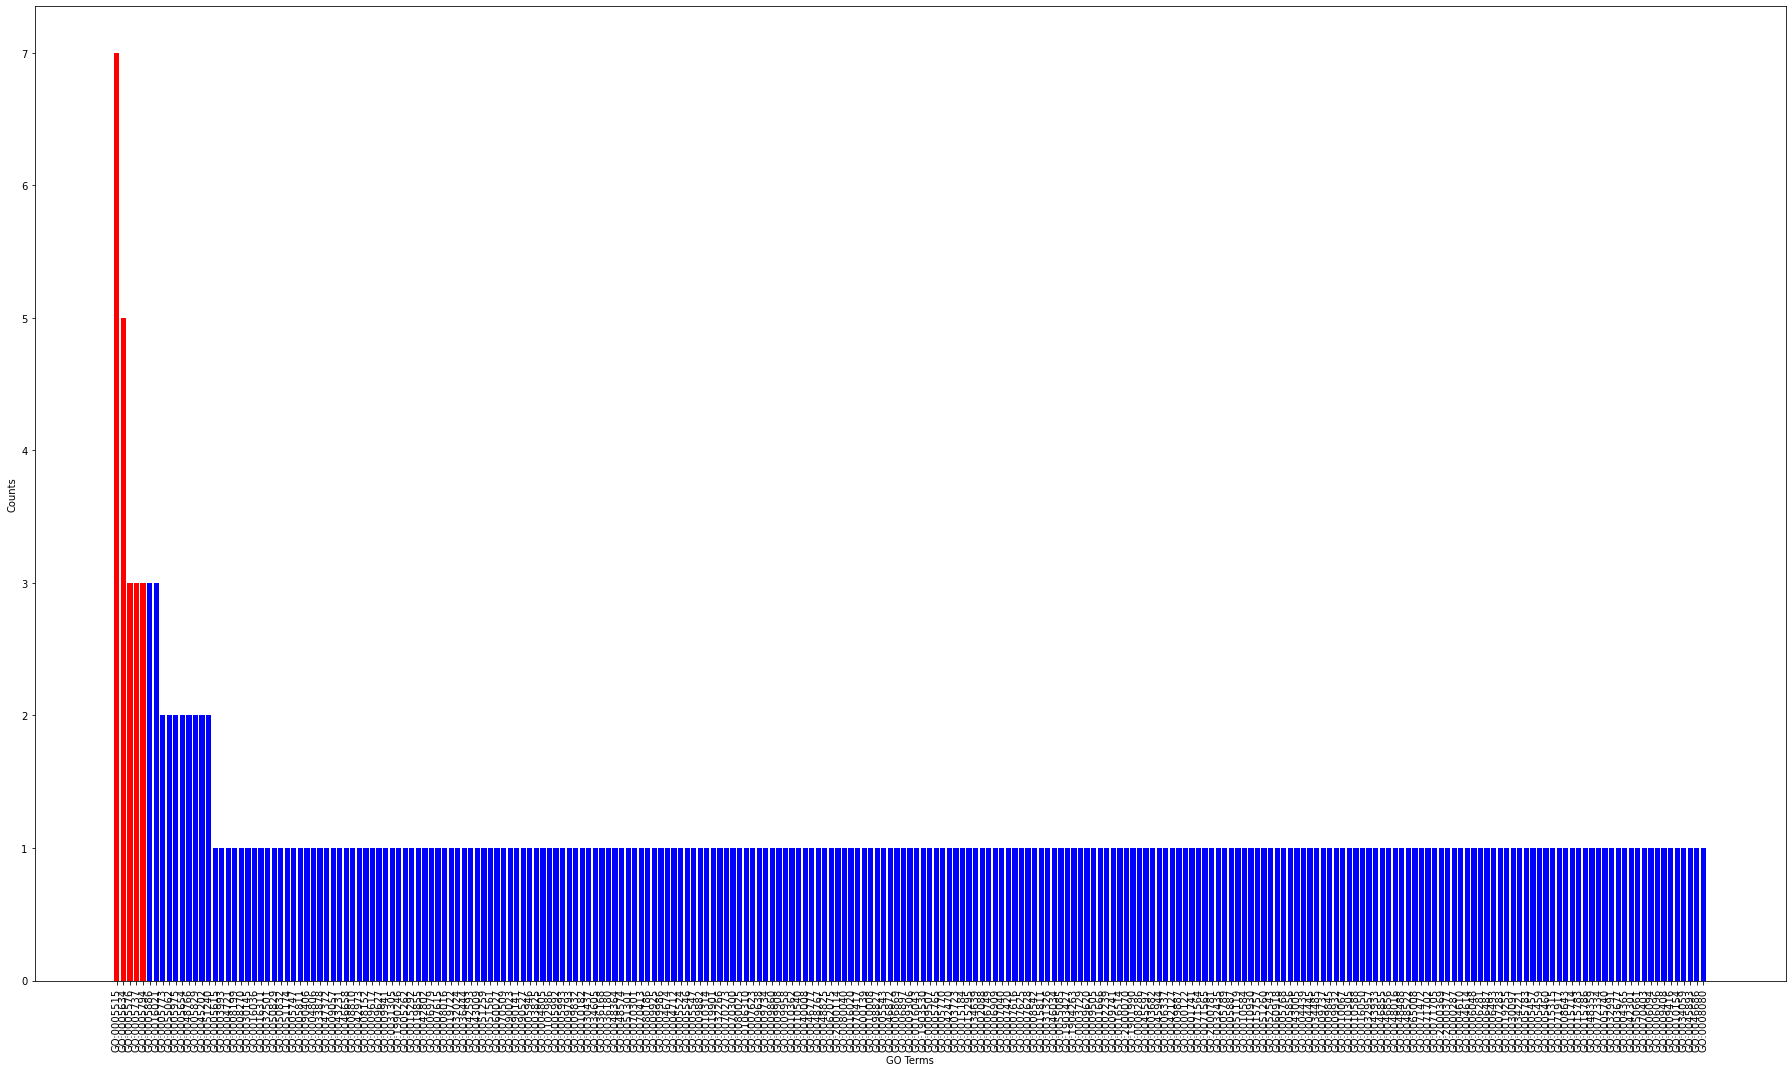

<<< GLUCOSE >>>
10x3FoldCV mean score: 0.37702307897847137 
count common features: 26
GO Term Occurrences for glucose, 5 most abundant terms are highlighted in red
('GO:0005515', ('protein binding', 7))
('GO:0005634', ('nucleus', 5))
('GO:0005576', ('extracellular region', 3))
('GO:0005737', ('cytoplasm', 3))
('GO:0005794', ('Golgi apparatus', 3))


In [127]:
go_terms = list(glucose_term_count.keys())
counts = [glucose_term_count[term][1] for term in go_terms]

# Sort the terms by count and identify top 3 features
sorted_terms = sorted(glucose_term_count.items(), key=lambda x: x[1][1], reverse=True)
top_terms = sorted_terms[:5]

# Create lists for the plot
terms_to_plot = [term for term, _ in sorted_terms]
counts_to_plot = [count for _, (_, count) in sorted_terms]

# Colors - highlight top 3 in red, others in blue
colors = ['red' if term in [t[0] for t in top_terms] else 'blue' for term in terms_to_plot]

# Create the bar plot
plt.figure(figsize=(25, 15))
plt.bar(terms_to_plot, counts_to_plot, color=colors)
plt.xlabel('GO Terms')
plt.ylabel('Counts')
plt.xticks(rotation=90)
#plt.title('GO Term Occurrences with Top 3 Features Highlighted')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping


plt.show()
print("<<< GLUCOSE >>>")
print(f"10x3FoldCV mean score: {np.mean(glucose_nXcv['mean_scores'])} \ncount common features: {len(glucose_nXcv['common_features'])}")
print(f'GO Term Occurrences for glucose, 5 most abundant terms are highlighted in red')
for t in top_terms:
    print(t)


In [110]:
"""PRINT EACH GFF ENTRY AND GO-TERMS CORRESPONDING TO NO-ZERO FEATURES"""
#for ele in glucose_nXcv_matched:
#    print(f"{glucose_nXcv_matched[ele]}")
#    #print(glucose_goids[ele], "\n")
#    for id in glucose_goids[ele]:
#        print(id, ": ", glucose_goids[ele][id])

'PRINT EACH GFF ENTRY AND GO-TERMS CORRESPONDING TO NO-ZERO FEATURES'

### Sucrose

In [122]:
with open("./models/sucrose_nXcv.json", 'r') as file:
    sucrose_nXcv = json.load(file)
#sucrose_nXcv_matched, sucrose_goids, sucrose_term_count,sucrose_goea = matchgff2(sucrose_nXcv['common_features'], goea=True)
sucrose_nXcv_matched, sucrose_goids, sucrose_term_count = matchgff2(sucrose_nXcv['common_features'], goea=False)



/home/t44p/PW_rawdata/go_obo/go.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms


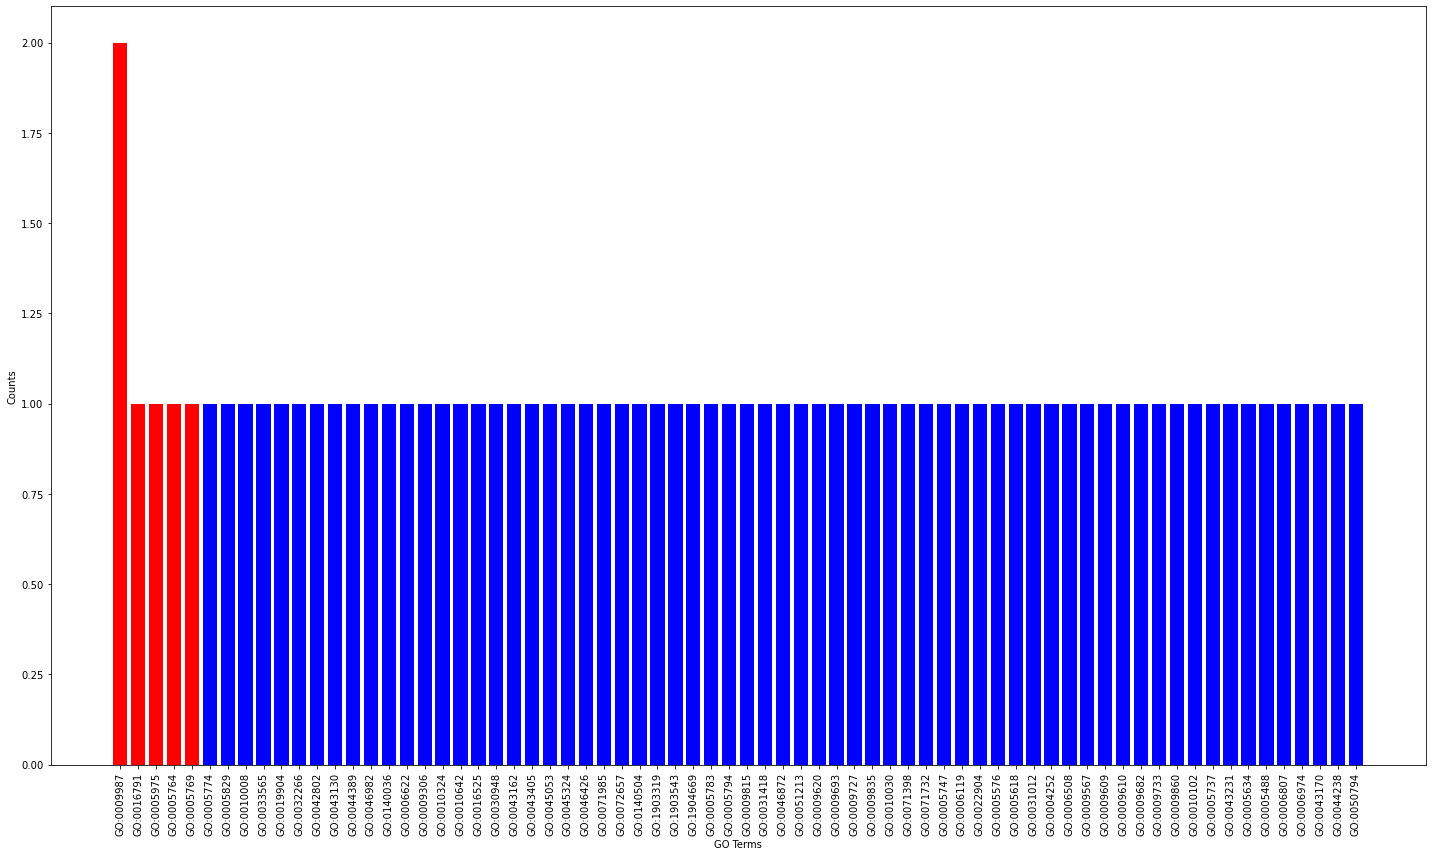

<<< SUCROSE >>>
10x3FoldCV mean score: 0.31889166659943624 
count common features: 8
GO Term Occurrences for sucrose, 5 most abundant terms are highlighted in red
('GO:0009987', ('cellular process', 2))
('GO:0016791', ('phosphatase activity', 1))
('GO:0005975', ('carbohydrate metabolic process', 1))
('GO:0005764', ('lysosome', 1))
('GO:0005769', ('early endosome', 1))


In [123]:
go_terms = list(sucrose_term_count.keys())
counts = [sucrose_term_count[term][1] for term in go_terms]

# Sort the terms by count and identify top 3 features
sorted_terms = sorted(sucrose_term_count.items(), key=lambda x: x[1][1], reverse=True)
top_terms = sorted_terms[:5]

# Create lists for the plot
terms_to_plot = [term for term, _ in sorted_terms]
counts_to_plot = [count for _, (_, count) in sorted_terms]

# Colors - highlight top 3 in red, others in blue
colors = ['red' if term in [t[0] for t in top_terms] else 'blue' for term in terms_to_plot]

# Create the bar plot
plt.figure(figsize=(20, 12))
plt.bar(terms_to_plot, counts_to_plot, color=colors)
plt.xlabel('GO Terms')
plt.ylabel('Counts')
plt.xticks(rotation=90)
#plt.title('GO Term Occurrences with Top 3 Features Highlighted')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping

plt.show()
print("<<< SUCROSE >>>")
print(f"10x3FoldCV mean score: {np.mean(sucrose_nXcv['mean_scores'])} \ncount common features: {len(sucrose_nXcv['common_features'])}")
print(f'GO Term Occurrences for sucrose, 5 most abundant terms are highlighted in red')
for t in top_terms:
    print(t)

In [113]:
"""PRINT EACH GFF ENTRY AND GO-TERMS CORRESPONDING TO NO-ZERO FEATURES"""

#for ele in sucrose_nXcv_matched:
#    print(f"{sucrose_nXcv_matched[ele]}")
#    #print(glucose_goids[ele], "\n")
#    for id in sucrose_goids[ele]:
#        print(id, ": ", sucrose_goids[ele][id])

'PRINT EACH GFF ENTRY AND GO-TERMS CORRESPONDING TO NO-ZERO FEATURES'

### citric acid

In [124]:
with open("./models/citricAcid_nXcv.json", 'r') as file:
    citricAcid_nXcv = json.load(file)
#citricAcid_nXcv_matched, citricAcid_goids, citricAcid_term_count, citricAcid_goea = matchgff2(citricAcid_nXcv['common_features'], goea=True)
citricAcid_nXcv_matched, citricAcid_goids, citricAcid_term_count = matchgff2(citricAcid_nXcv['common_features'], goea=False)


/home/t44p/PW_rawdata/go_obo/go.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms


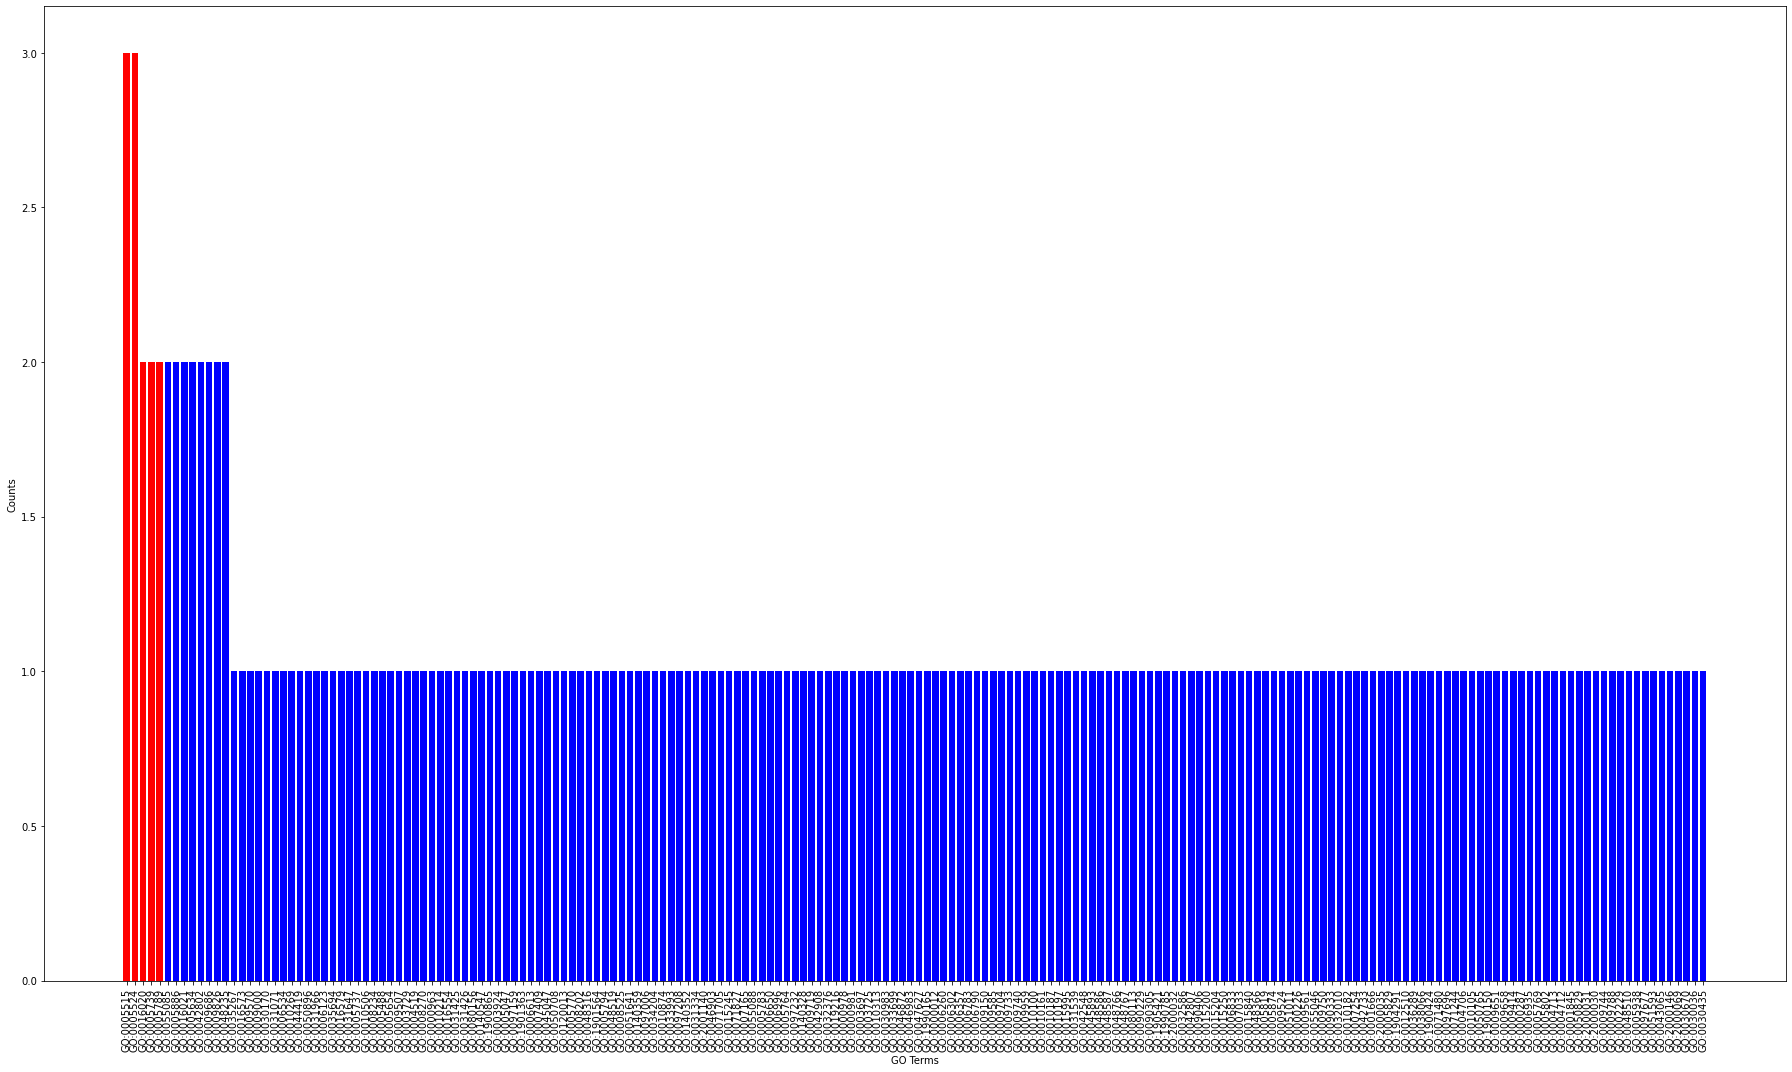

<<< CITRIC ACID >>>
10x3FoldCV mean score: 0.22358901669508696 
count common features: 18
GO Term Occurrences for sucrose, 5 most abundant terms are highlighted in red
('GO:0005515', ('protein binding', 3))
('GO:0005524', ('ATP binding', 3))
('GO:0016020', ('membrane', 2))
('GO:0005739', ('mitochondrion', 2))
('GO:0005789', ('endoplasmic reticulum membrane', 2))


In [126]:
# Assuming 'sucrose_term_count' is your dictionary with GO terms and counts
go_terms = list(citricAcid_term_count.keys())
counts = [citricAcid_term_count[term][1] for term in go_terms]

# Sort the terms by count and identify top 3 features
sorted_terms = sorted(citricAcid_term_count.items(), key=lambda x: x[1][1], reverse=True)
top_terms = sorted_terms[:5]

# Create lists for the plot
terms_to_plot = [term for term, _ in sorted_terms]
counts_to_plot = [count for _, (_, count) in sorted_terms]

# Colors - highlight top 3 in red, others in blue
colors = ['red' if term in [t[0] for t in top_terms] else 'blue' for term in terms_to_plot]

# Create the bar plot
plt.figure(figsize=(25, 15))
plt.bar(terms_to_plot, counts_to_plot, color=colors)
plt.xlabel('GO Terms')
plt.ylabel('Counts')

plt.xticks(rotation=90)
#plt.title('GO Term Occurrences with Top 3 Features Highlighted')
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping


plt.show()


print("<<< CITRIC ACID >>>")
print(f"10x3FoldCV mean score: {np.mean(citricAcid_nXcv['mean_scores'])} \ncount common features: {len(citricAcid_nXcv['common_features'])}")
print(f'GO Term Occurrences for sucrose, 5 most abundant terms are highlighted in red')
for t in top_terms:
    print(t)

In [ ]:
"""PRINT EACH GFF ENTRY AND GO-TERMS CORRESPONDING TO NO-ZERO FEATURES"""

#for ele in citricAcid_nXcv_matched:
#    print(f"{citricAcid_nXcv_matched[ele]}")
#    #print(glucose_goids[ele], "\n")
#    for id in citricAcid_goids[ele]:
#        print(id, ": ", citricAcid_goids[ele][id])

'PRINT EACH GFF ENTRY AND GO-TERMS CORRESPONDING TO NO-ZERO FEATURES'

# GO Enrichment Analysis

### `GOEnrichmentStudy` object in `goatools`, key arguments:

1. **`pop`**:
   - The population parameter represents all possible items that could be sampled. In the context of GO enrichment, it's typically the list of all gene IDs from your background set.

2. **`assoc`**:
   - The association between your items (genes) and the groups (GO terms). This is a dictionary where keys are gene IDs and values are sets of GO IDs.

3. **`obo_dag`**:
   - An object representing the GO terms and their hierarchical relationships, usually obtained by parsing the GO OBO file with `obo_parser.GODag()`.

4. **`propagate_counts`** (optional, default `True`):
   - If `True`, the gene counts will be propagated up the GO DAG, so that each term includes counts for all descendant terms.

5. **`alpha`** (optional, default `0.05`):
   - The significance level for the statistical tests.

6. **`methods`** (optional):
   - The methods for multiple test correction, such as `['fdr_bh']` for Benjamini-Hochberg.

7. **`pvalcalc`** (optional):
   - The object for calculating p-values. By default, `goatools` uses Fisher's exact test.

8. **`min_overlap`** (optional, default `0.7`):
   - The minimum overlap between the study group and the GO term.

9. **`prunetree`** (optional, default `True`):
   - If `True`, GO terms without any associated genes in the population will be pruned from the analysis.

10. **`go2geneids`** (optional):
    - A dictionary mapping GO IDs to gene IDs. This can be used instead of `assoc` to provide associations.

11. **`geneid2symbol`** (optional):
    - A dictionary mapping gene IDs to gene symbols, which can be useful for labeling output.

12. **`evidence_set`** (optional):
    - A set of evidence codes to use. If not specified, all evidence codes will be included.

13. **`relationships`** (optional):
    - A set of extra relationship types to include when building the GO DAG, such as `'part_of'` or `'regulates'`.

14. **`keep_if_no_id`** (optional, default `False`):
    - If `True`, genes without GO IDs in the `assoc` will be kept in the population.

15. **`study`**:
    - A list of items (genes) for which you want to check enrichment. This is typically the list of genes corresponding to your non-zero features.


The `GOEnrichmentStudy` class in the `goatools` library key attributes:

1. **`goterm`**:
   - This attribute is an object representing the GO term itself. It contains further details about the term, like its name, namespace, and description.

2. **`p_uncorrected`**:
   - The raw, uncorrected p-value resulting from the enrichment test (e.g., Fisher's exact test).

3. **`p_fdr_bh`**:
   - The p-value adjusted for multiple testing using the Benjamini-Hochberg false discovery rate method.

4. **`enrichment`**:
   - This indicates whether the GO term is overrepresented (`'e'` for enriched) or underrepresented (`'p'` for purified) in the study set compared to the background.

5. **`ratio_in_study`**:
   - A tuple showing the number of genes in the study set that are annotated with this GO term and the total number of genes in the study set.

6. **`ratio_in_pop`**:
   - A tuple showing the number of genes in the background population that are annotated with this GO term and the total number of genes in the background population.

7. **`study_items`**:
   - A list of genes from your study set that are annotated with this GO term.

8. **`study_count`**:
   - The number of genes in your study set that are annotated with this GO term.

9. **`pop_count`**:
   - The number of genes in the background population that are annotated with this GO term.

10. **`study_n`**:
    - The total number of genes in your study set.

11. **`pop_n`**:
    - The total number of genes in the background population.

12. **`name`** (if available):
    - The name of the GO term.

13. **`namespace`** (if available):
    - The namespace/category of the GO term, such as Biological Process, Molecular Function, or Cellular Component.

14. **`depth`** (if available):
    - The depth of the GO term in the GO hierarchy.

15. **`is_obsolete`** (if available):
    - Indicates whether the GO term is obsolete.

Remember, the availability of some of these attributes might depend on the specifics of how `GOEnrichmentStudy` is set up and run, and the version of `goatools` you are using. These attributes provide a comprehensive view of each GO term's enrichment analysis results, allowing for detailed interpretation and further analysis.

https://github.com/tanghaibao/goatools/blob/main/notebooks/goea_nbt3102.ipynb

In [ ]:
glucose_goea_sig = [r for r in glucose_goea if r.p_fdr_bh < 0.05]
citricAcid_goea_sig = [r for r in citricAcid_goea if r.p_fdr_bh < 0.05]
sucrose_goea_sig = [r for r in sucrose_goea if r.p_fdr_bh < 0.05]
print(f"{len(glucose_goea_sig), len(citricAcid_goea_sig), len(sucrose_goea_sig)}")

(236, 190, 70)
